In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scsavailability as scs
    
import statsmodels.api as sm
from scipy import stats

from scsavailability import features as feat, model as md, plotting as pt, score as sc

2021-01-05 08:33:45,705 - NumExpr defaulting to 8 threads.


In [2]:
path = '../raw_data/'

In [3]:
at = pd.read_csv(path+'active_totes_20201210.csv')
av = pd.read_csv(path+'Availability_with_Grey&Blue_1811-0912.csv',names = ["timestamp","Pick Station","Availability","Blue Tote Loss","Grey Tote Loss"])
#fa = pd.read_csv(path + 'scs_tote_matched.csv')
scs_raw = pd.read_csv(path + 'Faults20_11-10_12.csv')

In [4]:
fa = feat.add_code(scs_raw)
fa, unmapped = feat.add_tote_colour(fa)

Running: Function "load_tote_lookup" (id=1724755278576) was called 1 times


In [5]:
at = feat.pre_process_AT(at)

Running: Function "pre_process_AT" (id=1724755279440) was called 1 times


In [6]:
av = feat.pre_process_av(av)

Running: Function "pre_process_av" (id=1724755279728) was called 1 times


In [7]:
fa = feat.preprocess_faults(fa,remove_same_location_faults = True)

Running: Function "preprocess_faults" (id=1724755278000) was called 1 times
Running: Function "load_module_lookup" (id=1724755276704) was called 1 times
Running: Function "load_ID_lookup" (id=1724755277424) was called 1 times
duplicated location faults removed - max duration kept
HOTFIX: Quadrant only faults, PTT Asset Code update


In [8]:
fa_floor = feat.floor_shift_time_fa(fa, shift=15)

Time shifted by 15Minutes


In [9]:
fa_agg = feat.faults_aggregate(fa_floor,fault_agg_level= 'Asset Code', agg_type = 'count')

In [10]:
av_sel,at_sel = feat.av_at_select(av, at, remove_high_AT = True, AT_limit = None)

av_agg = feat.aggregate_availability(av_sel, agg_level = 'Quadrant')
at_agg = feat.aggregate_totes(at_sel, agg_level = 'Quadrant')

Running: Function "aggregate_availability" (id=1724755278432) was called 1 times


In [11]:
df = feat.merge_av_fa_at(av_agg ,at_df=at_agg, fa_df = fa_agg , agg_level = 'Quadrant')

In [1]:
df['Availability'] = 1 - df['Downtime']

NameError: name 'df' is not defined

In [ ]:
def log_totes(df):
    """
    
    """
    df = df.drop(['Downtime'], axis=1)
    df = df[df['TOTES'] > 5]
    df['log_totes'] = np.log(df['TOTES'])
    
    return df

In [13]:
X,y = md.gen_feat_var(df,target = 'Availability', features = ['Totes','Faults'])

(0.0, 5.0)

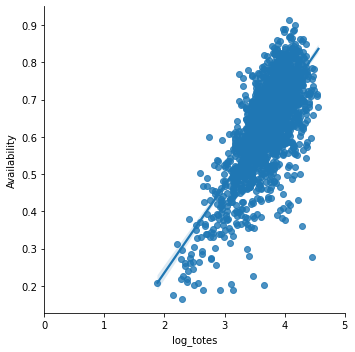

In [14]:
sns.lmplot(x='log_totes', y='Availability', data=df)
plt.xlim(0, 5)

In [15]:
X_train, X_test, y_train, y_test = md.split(X[['log_totes']],y)

Linear_mdl,predictions_LM,Coeff,fit_metrics = md.run_LR_model(X_train, X_test, y_train, y_test)

cv_R2 = md.cross_validate_r2(Linear_mdl, X[['log_totes']], y, n_folds = 5, shuffle = True, random_state = 101)


Cross Validation Scores LinearRegression(): 
 
        R2 Scores
1       0.428127
2       0.502099
3       0.609369
4       0.526976
5       0.473349
Mean    0.507984
STD     0.060417


In [16]:
Linear_mdl.coef_

array([0.23689209])

### Add LM - metrics

In [ ]:
X_train, X_test, y_train, y_test = md.split(X, y)

In [ ]:
X_train_rd = X_train
X = 10

def find_features(X_train, y_train, X):
    max_p = 1
    while max_p > 0.1:
        model = sm.OLS(y_train, X_train)
        results = model.fit()
        top_X = results.pvalues.sort_values(ascending=False).head(X)
        max_p = top_X.tail(1).values[0]
        rm_col = list(results.pvalues.sort_values(ascending=False).head(X).index)
        X_train = X_train.drop(rm_col, axis=1)
    return X_train.columns

In [ ]:
cols = find_features(X_train=X_train_rd, y_train=y_train, X=X)

In [ ]:
model = sm.OLS(y_train, X_train[cols])
results = model.fit()
print(results.summary())

1. Select negative Coeffs
2. Take "recent faults" - ////////////////////////////////////////////////////[///////]
4. PS Fault data cut
5. Merge with Coefficients (on=Asset Code)
6. Coefficient * Duration (or 1/0 occurrence)
7. Output: Lost time = (6) (at pick station from Asset code fault)
8. Append (4) together - feed into dashboard
- group by Asset Code, sum lost time

In [ ]:
filt_columns = X[keep_features]
X_train, X_test, y_train, y_test = md.split(X[keep_features],y)

Linear_mdl,predictions_LM,Coeff,fit_metrics = md.run_LR_model(X_train, X_test, y_train, y_test,
                                                              fit_intercept=False)

cv_R2 = md.cross_validate_r2(Linear_mdl, X_train[keep_features], y)

# Hold out Test X_test -> y_test

#y_prediction =  results.predict(X_test)

# plt.scatter(y_prediction,y_test)

# from sklearn.metrics import r2_score
# print(r2_score(y_prediction,y_test))

In [ ]:
print(results.summary())

In [ ]:
fa_Both = fa[fa['Tote Colour']=="Both"]
fa_Both = fa_Both[fa_Both['Pick Station']==False]
fa_Both[fa_Both['Desk']!="Z"]['Asset Code'].value_counts()

In [ ]:
fa[fa['Fault ID']==7647]

In [ ]:
fa[fa['Pick Station']!=False]['Asset Code'].value_counts()

In [ ]:
X

In [ ]:
y

In [ ]:
at_agg.loc["2020-11-20":].head(50)